This is a pytorch GPU pipeline for trianing a model for image classification. Dataset used is tf flowers, it has 5 classes of flowers. 

## Imports

In [29]:
import torch, os, cv2
from torch import nn
import torchvision
import numpy as np
import albumentations as A
import torchvision.models as models
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (15,8)

seed = 2048
def seed_torch(seed=2021):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed)

In [2]:
# !pip install albumentations -U
A.__version__

'0.5.2'

## Download Dataset

In [5]:
import tensorflow as tf

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='flower_photos', 
                                   untar=True)
os.listdir(data_dir)

['LICENSE.txt', 'dandelion', 'tulips', 'sunflowers', 'roses', 'daisy']

In [4]:
p1 = "/root/.keras/datasets/flower_photos/tulips/"
p2 = "/root/.keras/datasets/flower_photos/daisy/"
p3 = "/root/.keras/datasets/flower_photos/sunflowers/"
p4 = "/root/.keras/datasets/flower_photos/roses/"
p5 = "/root/.keras/datasets/flower_photos/dandelion/"

# Show sample 

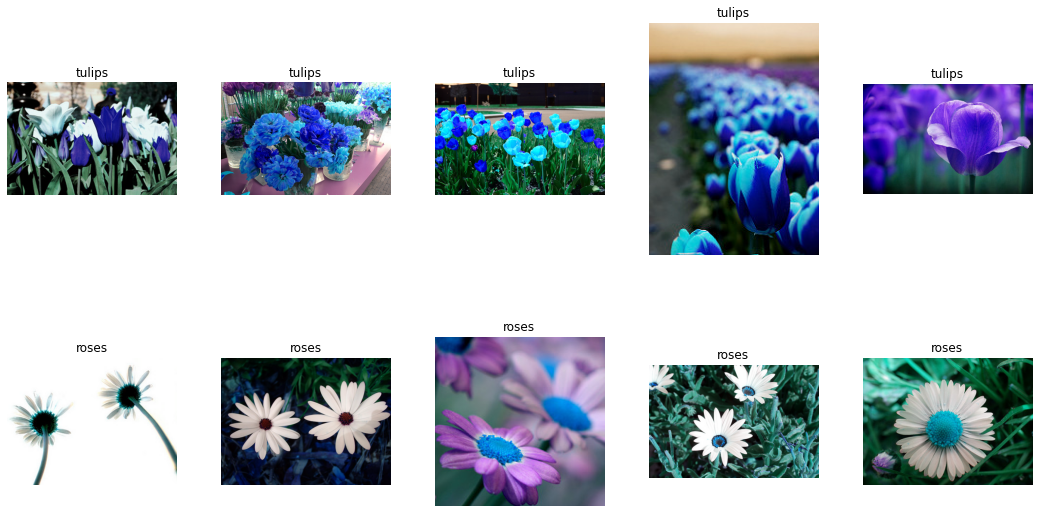

In [30]:
# sample some images

sample_imgs = [p1+i for i in os.listdir(p1)[:5]]
sample_imgs = sample_imgs + [p2+j for j in os.listdir(p2)[:5]]
sample_labels = ["tulips"]*5 + ["roses"]*5

r,c = 2,5
f, axs = plt.subplots(r,c)
f.tight_layout()
a= 0

for i in range(r):
  for j in range(c):
    im = cv2.imread(sample_imgs[a])
    axs[i,j].imshow(im)
    axs[i,j].set_title(sample_labels[a])
    axs[i,j].axis('off')
    a+=1

# Prepare Dataset

In [7]:
class MakeDataset(Dataset):
    def __init__(self,images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform  = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = torch.tensor(self.labels[idx]).long()
        image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # image = self.transform(image)   
        augmented = self.transform(image=image) # for albumentation
        image = augmented['image']

        return image, label    

In [8]:
# split dataset

images_dirs = [p1, p2, p3, p4, p5]
all_images = []
labels = []
for id, img_dir in enumerate(images_dirs):
  for i in os.listdir(img_dir):
      all_images.append(img_dir+i)
      labels.append(id)

X_train, X_test, Y_train, Y_test = train_test_split(all_images, labels, test_size= 0.3)

print('Total Train samples:', len(Y_train))
print('Total Test samples:', len(Y_test))    

Total Train samples: 2569
Total Test samples: 1101


## Data augumentations

In [9]:
batch_size = 128


# transform_train = transforms.Compose([
#     transforms.RandomCrop(32, padding=4),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
# ])

# transform_test = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
# ])

# train_dataset = MakeDataset(X_train, Y_train, transform=transform_train)
# val_dataset = MakeDataset(X_test, Y_test, transform=transform_test)

# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=4, pin_memory=True)
# val_loader = DataLoader(val_dataset, batch_size=valid_batch_size, shuffle=False, num_workers=4, pin_memory=True)

#----------------- or --------------------------

from albumentations.pytorch import ToTensorV2

transforms_train = A.Compose([
   A.HorizontalFlip(p=0.5),
  A.Resize(224, 224),
  A.Normalize(),
  ToTensorV2(p=1.0),
])

transforms_valid = A.Compose([
    A.Resize(224, 224),
    A.Normalize(),
    ToTensorV2(p=1.0),
])

train_dataset = MakeDataset(X_train, Y_train, transform=transforms_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=4, pin_memory=True)

val_dataset = MakeDataset(X_test, Y_test, transform=transforms_valid)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

In [10]:
val_dataset[0][0].shape

torch.Size([3, 224, 224])

## Prepare model

In [31]:
model = models.resnet18(pretrained=True).cuda(0)
model.fc = torch.nn.Linear(in_features=512, out_features=10).cuda(0)
model.fc.requires_grad_(True)

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total Trainable Parameters:", pytorch_total_params)

Total Trainable Parameters: 11181642


## Trainer functions

In [25]:
def train_one_epoch(train_loader):
    model.train()
    running_loss = 0.0
    for images, targets in train_loader:
        images, targets = images.to('cuda'), targets.to('cuda')
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        running_loss += loss.item()
    return running_loss

def val_one_epoch(valid_loader):
    model.eval()
    running_loss = 0.0
    correct = 0.0

    for images, targets in valid_loader:
        images, targets = images.to('cuda'), targets.to('cuda')
        with torch.no_grad(): 
            outputs = model(images)
        loss = criterion(outputs, targets)
        running_loss += loss.item()    
        _, outputs = torch.max(outputs,1)
        correct += torch.eq(outputs, targets).sum().item()
    return running_loss, correct

## Training

In [33]:
%%time

LR = 0.001
EPOCHS = 5
MAX_SCORE = 50.0
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, EPOCHS, eta_min=1e-7)
criterion = torch.nn.CrossEntropyLoss()
TRAIN_STEP = len(train_dataset)/batch_size
VALID_STEP = len(val_dataset)/batch_size
model_save_path = 'no-aug-ranzcr-inception_v3.bin'

TRAIN_LOSS = []
VAL_LOSS = []
VAL_ACC = []

for epoch in range(1, EPOCHS+1):

  print("Epoch", epoch)
  train_l = train_one_epoch(train_loader)
  train_l = train_l/TRAIN_STEP
  TRAIN_LOSS.append(train_l)
  print("Training loss:", train_l)

  valid_l, correct = val_one_epoch(val_loader)
  valid_l = valid_l/VALID_STEP
  print("Valid loss:", valid_l)
  VAL_LOSS.append(valid_l)

  valid_a = (correct / len(val_dataset)) * 100
  print('Valid Accuracy: %d %%' % valid_a)
  VAL_ACC.append(valid_a)

  scheduler.step()

  if MAX_SCORE < valid_a:
      MAX_SCORE = valid_a
      torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'schduler': scheduler.state_dict()
                }, model_save_path)
      print('Model Saved...')
  print('')   

Epoch 1
Training loss: 0.5617943686147105
Valid loss: 5.858988610318744
Valid Accuracy: 55 %
Model Saved...

Epoch 2
Training loss: 0.30637233996957414
Valid loss: 0.9500699368094878
Valid Accuracy: 76 %
Model Saved...

Epoch 3
Training loss: 0.2018745759434624
Valid loss: 0.45732740701923147
Valid Accuracy: 85 %
Model Saved...

Epoch 4
Training loss: 0.12541975646503428
Valid loss: 0.38559136663535637
Valid Accuracy: 89 %
Model Saved...

Epoch 5
Training loss: 0.06807332606852032
Valid loss: 0.29637317761413406
Valid Accuracy: 91 %
Model Saved...

CPU times: user 19.4 s, sys: 16.9 s, total: 36.4 s
Wall time: 1min 26s


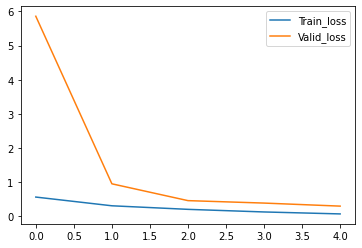

In [38]:
# draw graph for train and valid loss
plt.rcParams["figure.figsize"] = (6,4)

a = np.arange(0,EPOCHS)
plt.plot(a, TRAIN_LOSS, label="Train_loss")
plt.plot(a, VAL_LOSS, label="Valid_loss")
plt.legend()
plt.show()